<a href="https://colab.research.google.com/github/Duygubirol/Humor-Detection---NLP/blob/main/Humor_detection_with_Bert___revised_11_04_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fine-tuning a pretrained transformer BERT model for customized sentiment analysis using transformer PyTorch Trainer from Hugging Face

# Intro

Hugging Face provides three ways to fine-tune a pretrained text classification model: Tensorflow Keras, PyTorch, and transformer trainer. Transformer trainer is an API for feature-complete training in PyTorch without writing all the loops. This notebook will use the transformer trainer to fine-tune Bert. 
##This project follows CRISP-DM model:
* Step 1: Business Understanding
* Step 2: Data Understanding
* Step 3: Data Preparation
* Step 4: Modeling
* Step 5: Evaluation
* Step 6: Deployment



# Step 0: Install And Import Python Libraries

In [154]:
# Install libraries
!pip install transformers datasets
!pip install evaluate
!pip install scikit-plot
!pip install wordcloud
!pip install tensorflow
!pip install tensorflow-hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [155]:
# Data processing
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS

# Data Visualization
from matplotlib import pyplot as plt
import seaborn as sns

# Preprocessing and Modeling
import torch
import tensorflow as tf
from transformers import AutoTokenizer, AutoModelForSequenceClassification, EarlyStoppingCallback, TextClassificationPipeline
from transformers import TrainingArguments, Trainer
from datasets import Dataset
import re
import transformers
from transformers import BertModel, BertTokenizer, TFBertModel, TFBertForSequenceClassification, BertConfig, AdamW, get_linear_schedule_with_warmup
import string

# Model performance evaluation
import evaluate
from sklearn import metrics
from sklearn.metrics import classification_report
import scikitplot as skplt
import string
import random
import re
#import tensorflow_hub as hub
#from tensorflow import keras
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, classification_report

# seaborn settings
sns.set_theme(style="white",palette="viridis")
np.random.seed(1)
torch.manual_seed(1)


# Step 1: Business Understanding



Before proceeding with the project, it is crucial to have a clear understanding of its primary objective. The aim of this project is to develop an automated system for detecting humor in text, with the ultimate goal of integrating it with chatbots or virtual assistants to enable them to produce humorous responses.

# Step 2: Data Understanding with EDA

The second step is to download and read the dataset. Continue with EDA 



In [156]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The dataset comprises two columns: one containing the text and the other containing the corresponding sentiment label. Due to limited computational power, the first 40.000 rows were chosen for training and testing the data.

In [157]:
# Read the data
filepath = "/content/drive/Othercomputers/My Laptop/Documents/dataset.csv"
df_humor = pd.read_csv(filepath, nrows=5000)

# First 5 rows in the dataset
df_humor.head()

,text,humor
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",False
1,Watch: darvish gave hitter whiplash with slow ...,False
2,What do you call a turtle without its shell? d...,True
3,5 reasons the 2016 election feels so personal,False
4,"Pasco police shot mexican migrant from behind,...",False


There are 40.000 records and the `text` column is the `object` type and the `humor` column is the `int64` type.

In [158]:
# Get the dataset information
df_humor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5000 non-null   object
 1   humor   5000 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 44.1+ KB


The label value of 0 represents negative reviews and the label value of 1 represents positive reviews. The dataset has 500 positive reviews and 500 negative reviews. It is well-balanced, so we can use  accuracy as the metric to evaluate the model performance.

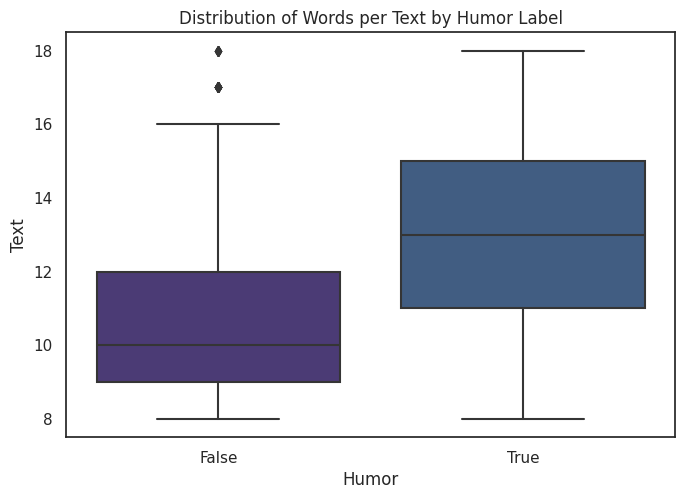

In [159]:
# Plot a boxplot of the number of words per tweet, grouped by label_name
sns.boxplot(x="humor", y=df_humor["text"].apply(lambda x: len(x.split())), data=df_humor)

# Set the plot title and x-label
plt.title("Distribution of Words per Text by Humor Label")
plt.xlabel("Humor")
plt.ylabel("Text")

# Display the plot
plt.show()

In [160]:
# It is mentioned in the article that dublicated rows are removed during creating new dataset.Let's see whether it is true or not.
# Check for duplicated columns
duplicated_columns = df_humor.columns.duplicated().sum()

# Print the number of duplicated columns
print(f'There are {duplicated_columns} duplicated columns in the DataFrame')

There are 0 duplicated columns in the DataFrame


In [161]:
# Check the label distribution
df_humor['humor'].value_counts()

True     2503
False    2497
Name: humor, dtype: int64

In [162]:
# Get max number of words
max_words = df_humor['text'].str.split().str.len().max()
print(f"The comment with the most words consists of {max_words} words.")

The comment with the most words consists of 18 words.


In [163]:
# Compute the length of each text and display descriptive statistics
df_humor['text'].apply(lambda x: len(x.split(' '))).describe()

count    5000.000000
mean       11.947600
std         2.770919
min         8.000000
25%        10.000000
50%        12.000000
75%        14.000000
max        20.000000
Name: text, dtype: float64

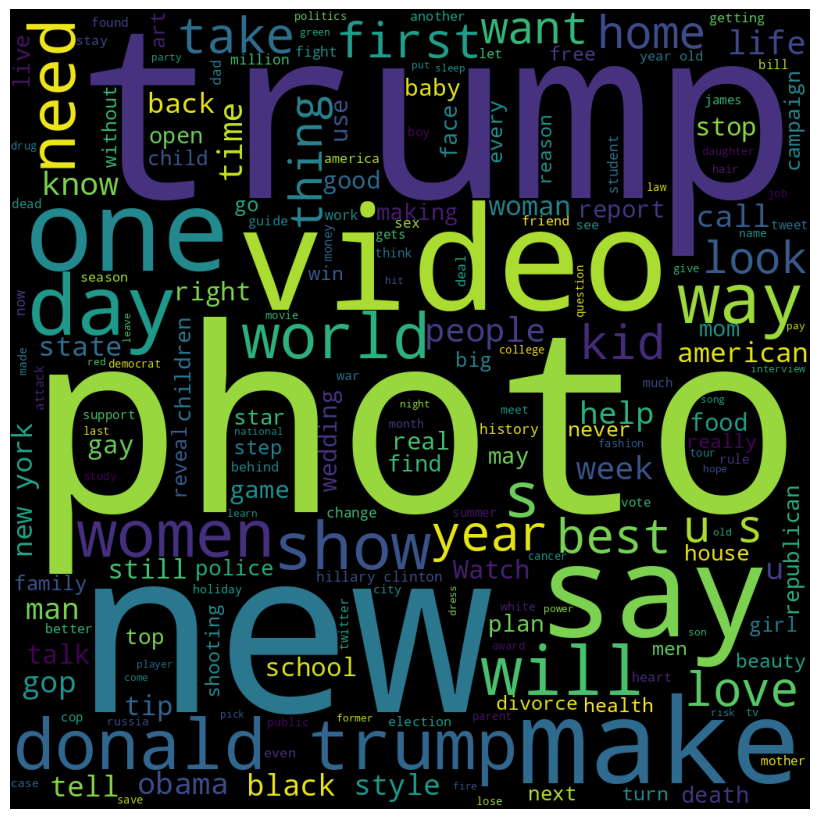

In [164]:
# Combine all non-humorous texts into a single string
all_nonhumorous_words = ' '.join(df_humor.loc[df_humor['humor'] == 0, 'text'].tolist())

# Generate the WordCloud
wc = WordCloud(width=1024, height=1024, min_font_size=8, stopwords=STOPWORDS).generate(all_nonhumorous_words)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wc)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()


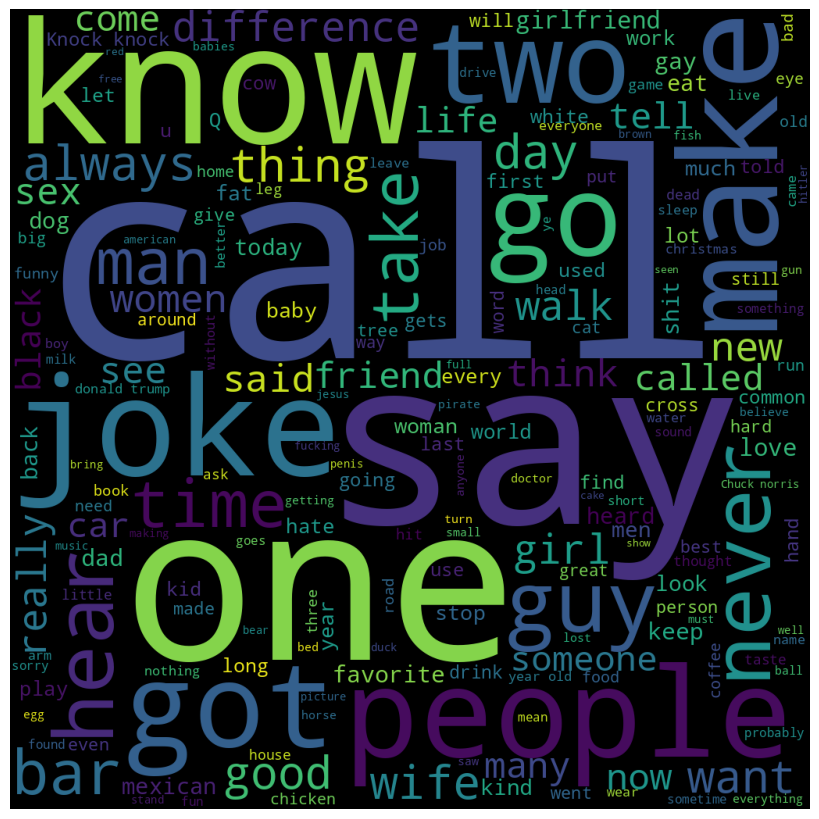

In [165]:
all_humorous_words = ' '.join(list(df_humor[df_humor['humor'] == 1]['text']))
wc = WordCloud(width=1024, height=1024, min_font_size=8, stopwords=STOPWORDS).generate(all_humorous_words)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wc)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()


<Axes: xlabel='Label', ylabel='Question_mark'>

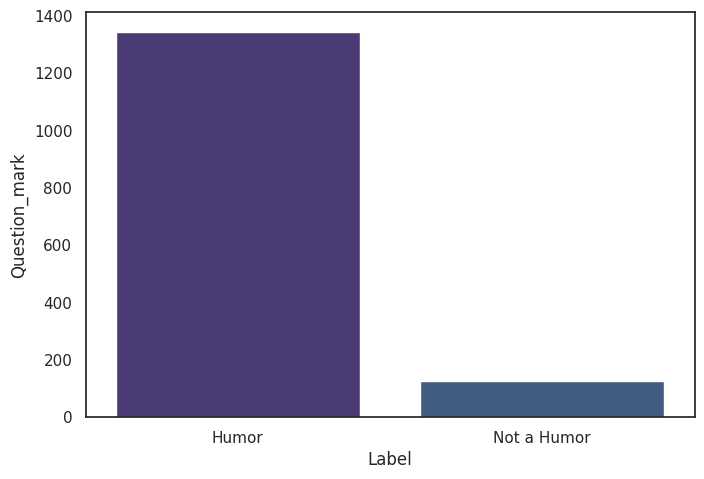

In [168]:
# Calculate how often "?" occurs in the data
humor_texts = df_humor[df_humor.humor == True]['text']
no_humor_texts = df_humor[df_humor.humor == False]['text']
qm_jokes = sum(['?' in text for text in humor_texts])
qm_no_jokes = sum(['?' in text for text in no_humor_texts])

# Create a dataframe to plot a bar chart
df_qm = pd.DataFrame({'Label':['Humor', 'Not a Humor'], 'Question_mark':[qm_jokes, qm_no_jokes]})

# Plot the bar chart
sns.set_palette("viridis")
sns.barplot(x='Label', y='Question_mark', data=df_qm)

# Step 3: Data Preparation





## Step 3.1: Prepare the data before tokenization

In [169]:
# Replace the labels to integer before being used by a machine learning model
df_humor['humor'] = np.where((df_humor["humor"] == 'False'), 0, df_humor['humor'])
df_humor['humor'] = np.where((df_humor['humor'] == 'True'), 1, df_humor['humor'])

# show head 
df_humor.head()

,text,humor
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",0
1,Watch: darvish gave hitter whiplash with slow ...,0
2,What do you call a turtle without its shell? d...,1
3,5 reasons the 2016 election feels so personal,0
4,"Pasco police shot mexican migrant from behind,...",0


Carry out several text preprocessing steps on all input texts to ensure data cleanliness

In [171]:
contraction_dict = {
    "ain't": "is not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "could've": "could have",
    "couldn't": "could not",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'll": "he will",
    "he's": "he is",
    "how'd": "how did",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'll": "i will",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'll": "it will",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "must've": "must have",
    "mustn't": "must not",
    "needn't": "need not",
    "oughtn't": "ought not",
    "shan't": "shall not",
    "she'd": "she would",
    "she'll": "she will",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "that'd": "that would",
    "that's": "that is",
    "there'd": "there had",
    "there's": "there is",
    "they'd": "they would",
    "they'll": "they will",
    "they're": "they are",
    "they've": "they have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'll": "we will",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "where'd": "where did",
    "where's": "where is",
    "who'll": "who will",
    "who's": "who is",
    "won't": "will not",
    "would've": "would have",
    "wouldn't": "would not",
    "you'd": "you would",
    "you'll": "you will",
    "you're": "you are",
    "you've": "you have",
    "'s": "is",
    "'re": "are",
    "'ll": "will",
    "'ve": "have",
    "'m": "am"
}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contraction_dict.keys()))
def expand_contractions(text,contractions_dict=contraction_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)
# Expanding Contractions in the reviews
df_humor["text"] = df_humor["text"].apply(lambda x: expand_contractions(x))

In [172]:
def remove_punctuation(text):
    """
    Remove punctuation from text
    """
    return text.translate(str.maketrans('', '', string.punctuation))

# Apply the function to the text column in the DataFrame
df_humor['text'] = df_humor['text'].apply(lambda x: remove_punctuation(x))
df_humor.head()

,text,humor
0,Joe biden rules out 2020 bid guys im not running,0
1,Watch darvish gave hitter whiplash with slow p...,0
2,What do you call a turtle without its shell dead,1
3,5 reasons the 2016 election feels so personal,0
4,Pasco police shot mexican migrant from behind ...,0


## Step 3.2: Split the dataset 

 80% as the training dataset and 20% as the testing dataset.

 `random_state=42` ensures that the sampling result is reproducible.

In [173]:
from sklearn.model_selection import train_test_split

# Split dataset into train and test sets
train_data, test_data = train_test_split(df_humor, test_size=0.2, random_state=42)

# Print number of records in train and test sets
print(f"The training dataset has {len(train_data)} records.")
print(f"The testing dataset has {len(test_data)} records.")

The training dataset has 4000 records.
The testing dataset has 1000 records.


## Step 3.3 : Convert Pandas Dataframe to Hugging Face Dataset

Step 3.3 involves converting both the training and testing datasets from pandas dataframes to the Hugging Face Dataset format. This is done using the `Dataset.from_pandas` function, which efficiently maps the datasets to disk to avoid memory limitations when working with large datasets.

One of the significant advantages of using the Hugging Face Dataset format is that it allows for efficient memory management, as the data can be memory-mapped to disk. This is particularly useful when dealing with large datasets that would otherwise exceed the available RAM memory.

In [174]:
# Convert pyhton dataframe to Hugging Face arrow dataset
hg_train_data = Dataset.from_pandas(train_data)
hg_test_data = Dataset.from_pandas(test_data)

## Step 3.4: Tokenize the data 

Use a tokenizer to transform the review text into numerical values. To ensure the same tokenization approach as the `bert-base-cased` model.

In [175]:
# Tokenizer from a pretrained model
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

# Take a look at the tokenizer
tokenizer

BertTokenizerFast(name_or_path='bert-base-cased', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [176]:
# Set the maximum length for tokenization
max_length = 100

# Function to tokenize data
def tokenize_dataset(data):
    return tokenizer(data["text"], 
                     max_length=100, 
                     truncation=True, 
                     padding="max_length")

# Tokenize the dataset
dataset_train = hg_train_data.map(tokenize_dataset)
dataset_test = hg_test_data.map(tokenize_dataset)


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

After tokenization, we can see that both the training and the testing Dataset have 6 features, `'review'`, `'label'`, `'__index_level_0__'`, `'input_ids'`, `'token_type_ids'`, and `'attention_mask'`. The number of rows is stored with `num_rows`.

In [177]:
# Take a look at the data
print(dataset_train)
print(dataset_test)

Dataset({
    features: ['text', 'humor', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 4000
})
Dataset({
    features: ['text', 'humor', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1000
})


# Step 4: Modeling

In Step 4, we will load the pretrained model for sentiment analysis.

* `AutoModelForSequenceClassification` loads the BERT model without the sequence classification head.
* The method `from_pretrained()` loads the weights from the pretrained model into the new model
* `num_labels` indicates the number of classes. Our dataset has two classes, positive and negative, so `num_labels=2`.

In [178]:
# Load model
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

## Step 4.1: Set Training Argument

 `TrainingArguments` provides a lot of flexibility in fine-tuning the transfer learning model. 


In [179]:
# Set up training arguments
training_args = TrainingArguments(
    output_dir="./sentiment_transfer_learning_transformer/",          
    logging_dir='./sentiment_transfer_learning_transformer/logs',            
    logging_strategy='epoch',
    logging_steps=100,    
    num_train_epochs=2,              
    per_device_train_batch_size=4,  
    per_device_eval_batch_size=4,  
    learning_rate=5e-6,
    seed=42,
    save_strategy='epoch',
    save_steps=100,
    evaluation_strategy='epoch',
    eval_steps=100,
    load_best_model_at_end=True
)

In [180]:
# Remove the review and index columns because it will not be used in the model
columns_to_remove = ["text", "__index_level_0__"]
dataset_train = dataset_train.remove_columns(columns_to_remove)
dataset_test = dataset_test.remove_columns(columns_to_remove)

# Rename label to labels because the model expects the name labels
columns_to_rename = {"humor": "labels"}
dataset_train = dataset_train.rename_columns(columns_to_rename)
dataset_test = dataset_test.rename_columns(columns_to_rename)

# Change the format to PyTorch tensors
dataset_train.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
dataset_test.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

print("Training dataset:", dataset_train)
print("Test dataset:", dataset_test)

Training dataset: Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 4000
})
Test dataset: Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1000
})


## Step 4.2: Set Evaluation Metrics

In [181]:
# Function to compute the metric
def compute_metrics(eval_pred):
    metric = evaluate.load("accuracy")
    logits, labels = eval_pred
    # probabilities = tf.nn.softmax(logits)
    predictions = np.argmax(logits, axis=1)
    return metric.compute(predictions=predictions, references=labels)

## Step 4.3: Train Model Using Transformer Trainer

 Train the model using the transformer `Trainer`.


In [182]:
# Train the model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_train,
    eval_dataset=dataset_test,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)

trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.395300,0.305038,0.924000
2,0.255900,0.290008,0.930000


TrainOutput(global_step=2000, training_loss=0.3256349639892578, metrics={'train_runtime': 237.0316, 'train_samples_per_second': 33.751, 'train_steps_per_second': 8.438, 'total_flos': 411111024000000.0, 'train_loss': 0.3256349639892578, 'epoch': 2.0})

# Step 5: Evaluation

# Step 5.1: Make Predictions for Text Classification and Model Performance Evaluation


The `trainer.evaluate` function provides a convenient way to obtain the loss and accuracy metrics for the testing dataset.

In [183]:
# Trainer evaluate
trainer.evaluate(dataset_test)

{'eval_loss': 0.2900077700614929,
 'eval_accuracy': 0.93,
 'eval_runtime': 7.1827,
 'eval_samples_per_second': 139.224,
 'eval_steps_per_second': 34.806,
 'epoch': 2.0}

Create a function to calculate metrics that are decided to apply to evaluate the test results.

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93       499
           1       0.93      0.94      0.93       501

    accuracy                           0.93      1000
   macro avg       0.93      0.93      0.93      1000
weighted avg       0.93      0.93      0.93      1000



{'accuracy': 0.93,
 'f1': 0.9299966397849462,
 'recall': 0.93,
 'precision': 0.9300602518093547,
 'confusion_matrix': <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x7f096d81d280>}

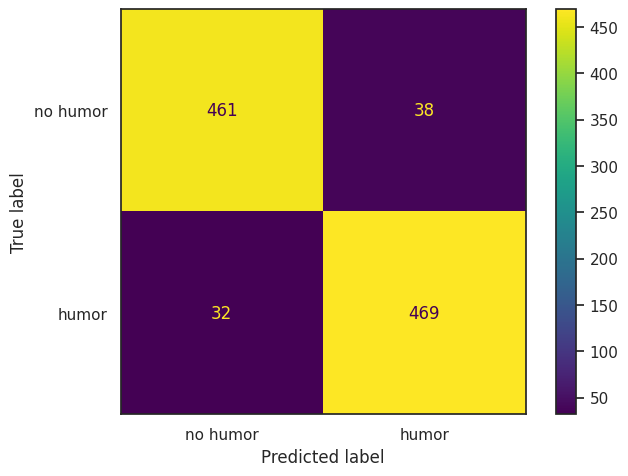

In [184]:
def compute_metrics(trainer, dataset_test):
    # Generate predictions
    y_test_predict = trainer.predict(dataset_test)
    
    # Extract the predicted logits, predicted probabilities, predicted labels, and actual labels
    y_test_logits = y_test_predict.predictions
    y_test_probabilities = tf.nn.softmax(y_test_logits)
    y_test_pred = np.argmax(y_test_probabilities, axis=1)
    y_test_labels = y_test_predict.label_ids
    
    # Calculate accuracy, f1, recall, and precision
    accuracy = accuracy_score(y_test_labels, y_test_pred)
    f1 = f1_score(y_test_labels, y_test_pred, average='weighted')
    recall = recall_score(y_test_labels, y_test_pred, average='weighted')
    precision = precision_score(y_test_labels, y_test_pred, average='weighted')
    
    # Plot confusion matrix
    plt.rcParams['figure.figsize'] = (7, 5)
    confusion_matrix = metrics.confusion_matrix(y_test_labels, y_test_pred)
    cm= metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["no humor", "humor" ])
    cm.plot()
    
    # Calculate classification report
    report = classification_report(y_test_labels, y_test_pred)
    
    # Print classification report
    print("Classification Report:\n", report)
    
    # Return the results as a dictionary
    return {'accuracy': accuracy,
            'f1': f1,
            'recall': recall,
            'precision': precision,
            'confusion_matrix': cm}

compute_metrics(trainer, dataset_test)


## Step 5.2: Save the Model

`tokenizer.save_pretrained` saves the tokenizer information to the drive and `model.save_model` saves the model to the drive.

In [151]:
# Save tokenizer
tokenizer.save_pretrained('./sentiment_transfer_learning_transformer/')

# Save model
trainer.save_model('./sentiment_transfer_learning_transformer/')